<a href="https://colab.research.google.com/github/rachelhostetler/ABCAtlasVignettes/blob/main/Plotting_gene_expression_in_NT_and_region_subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install s3fs package
!apt install s3fs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 297 kB of archives.
After this operation, 794 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 s3fs amd64 1.90-1 [297 kB]
Fetched 297 kB in 1s (266 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.90-1_amd64.deb ...
Unpacking s3fs (1.90-1) ...
Setting up s3fs (1.90-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [3]:
# Make directory to mount s3 data into
!mkdir -p /data/abc_atlas

In [4]:
# Mount the s3 bucket using s3fs-fuse
!s3fs -o public_bucket=1 -o default_acl=public-read -o endpoint="us-west-2" allen-brain-cell-atlas /data/abc_atlas

In [5]:
# Check that it's mounted
!ls -ltrh /data/abc_atlas

total 35K
drwxr-x--- 1 root root   0 Dec 31  1969 releases
drwxr-x--- 1 root root   0 Dec 31  1969 metadata
drwxr-x--- 1 root root   0 Dec 31  1969 mapmycells
drwxr-x--- 1 root root   0 Dec 31  1969 image_volumes
drwxr-x--- 1 root root   0 Dec 31  1969 expression_matrices
-rw-r----- 1 root root 32K Jun  7  2023 index.html


In [6]:
# Install abc_atlas_access
%pip install "abc_atlas_access[notebooks] @ git+https://github.com/alleninstitute/abc_atlas_access.git"

  Cloning https://github.com/alleninstitute/abc_atlas_access.git to /tmp/pip-install-_xmqnrrn/abc-atlas-access_ffee7a21b09f4f63b5fe64fc6514e9d5
  Running command git clone --filter=blob:none --quiet https://github.com/alleninstitute/abc_atlas_access.git /tmp/pip-install-_xmqnrrn/abc-atlas-access_ffee7a21b09f4f63b5fe64fc6514e9d5
  Resolved https://github.com/alleninstitute/abc_atlas_access.git to commit a82a6770c99ad166105c3e6fccd47f31ee69b44c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 134.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [7]:
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [8]:
download_base = Path('/data/abc_atlas')
abc_cache = AbcProjectCache.from_local_cache(download_base)

abc_cache.current_manifest

/usr/local/lib/python3.11/dist-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:470: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. Unless running as a LocalCache, files will be re-downloaded.
  warnings.warn(msg, MissingLocalManifestWarning)
/usr/local/lib/python3.11/dist-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:1373: ReadOnlyLocalCacheWarning: LocalCache is a read only directory and cannot
                save the last used manifest.
                Current Manifest: releases/20250331/manifest.json
  warnings.warn(


'releases/20250331/manifest.json'

In [9]:
abc_cache.list_directories

['ASAP-PMDBS-10X',
 'ASAP-PMDBS-taxonomy',
 'Allen-CCF-2020',
 'MERFISH-C57BL6J-638850',
 'MERFISH-C57BL6J-638850-CCF',
 'MERFISH-C57BL6J-638850-imputed',
 'MERFISH-C57BL6J-638850-sections',
 'SEAAD',
 'SEAAD-taxonomy',
 'WHB-10Xv3',
 'WHB-taxonomy',
 'WMB-10X',
 'WMB-10XMulti',
 'WMB-10Xv2',
 'WMB-10Xv3',
 'WMB-neighborhoods',
 'WMB-taxonomy',
 'Zeng-Aging-Mouse-10Xv3',
 'Zeng-Aging-Mouse-WMB-taxonomy',
 'Zhuang-ABCA-1',
 'Zhuang-ABCA-1-CCF',
 'Zhuang-ABCA-2',
 'Zhuang-ABCA-2-CCF',
 'Zhuang-ABCA-3',
 'Zhuang-ABCA-3-CCF',
 'Zhuang-ABCA-4',
 'Zhuang-ABCA-4-CCF']

In [10]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [11]:
cell = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='cell_metadata_with_cluster_annotation',
    dtype={"cell_label": str,
           "neurotransmitter": str}
)
cell.set_index('cell_label', inplace=True)

In [12]:
glut_cells = cell[cell['neurotransmitter'] == 'Glut']
glut_cells

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1017092617101300312,C57BL6J-638850.25,4218,0.708851,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.978776,7.843046,4.0,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017155956102670697,C57BL6J-638850.48,403,0.523509,C57BL6J-638850,C57BL6J-638850,wt/wt,M,9.098202,4.767086,9.0,Glut,01 IT-ET Glut,022 L5 ET CTX Glut,0090 L5 ET CTX Glut_1,0356 L5 ET CTX Glut_1,#2B93DF,#FA0087,#99A2FF,#5A0099,#663D60
1017155956102530085,C57BL6J-638850.48,133,0.517150,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.609080,3.661931,9.0,Glut,01 IT-ET Glut,004 L6 IT CTX Glut,0015 L6 IT CTX Glut_3,0047 L6 IT CTX Glut_3,#2B93DF,#FA0087,#C0FF4D,#661799,#B199FF
1018135614102270324,C57BL6J-638850.55,64,0.556958,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.385119,5.497882,10.4,Glut,02 NP-CT-L6b Glut,030 L6 CT CTX Glut,0114 L6 CT CTX Glut_1,0436 L6 CT CTX Glut_1,#2B93DF,#61e2a4,#34661F,#CC3D77,#349900


In [13]:
# coordinates
reconstructed_coords = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='reconstructed_coordinates',
    dtype={"cell_label": str}
)
reconstructed_coords.rename(columns={'x': 'x_reconstructed',
                                     'y': 'y_reconstructed',
                                     'z': 'z_reconstructed'},
                            inplace=True)
reconstructed_coords.set_index('cell_label', inplace=True)
reconstructed_coords.head(5)

,x_reconstructed,y_reconstructed,z_reconstructed,parcellation_index
cell_label,,,,
1019171911101460569,7.143894,7.890964,0.8,945
1019171911101550321,4.188673,7.962972,0.8,945
1019171911100841066,6.859447,5.908534,0.8,893
1019171911101400425,3.952014,7.564086,0.8,842
1019171911101380264,2.803546,7.221688,0.8,0


In [22]:
cell_joined = glut_cells.join(reconstructed_coords, how='inner')
cell_joined.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,...,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,x_reconstructed,y_reconstructed,z_reconstructed,parcellation_index
cell_label,,,,,,,,,,,,,,,,,,,,,
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,5.036436,7.264429,4.2,564
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,5.784270,8.007646,4.0,761
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,3.161528,5.719814,2.4,718
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,5.618763,7.847877,4.4,761
1017092617101300312,C57BL6J-638850.25,4218,0.708851,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.978776,7.843046,4.0,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,4.945694,7.763625,4.0,564


In [23]:
parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                           file_name='parcellation_to_parcellation_term_membership_acronym')
parcellation_annotation.set_index('parcellation_index', inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]
parcellation_annotation.head(5)

,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure
parcellation_index,,,,,
0,unassigned,unassigned,unassigned,unassigned,unassigned
1,brain,grey,HY,TMv,TMv
2,brain,grey,Isocortex,SSp-m,SSp-m6b
5,brain,fiber tracts,lfbs,cst,int
6,brain,grey,P,PSV,PSV


In [24]:
parcellation_color = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                      file_name='parcellation_to_parcellation_term_membership_color')
parcellation_color.set_index('parcellation_index', inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]
parcellation_color.head(5)

,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
parcellation_index,,,,,
0,#000000,#000000,#000000,#000000,#000000
1,#FFFFFF,#BFDAE3,#E64438,#FF4C3E,#FF4C3E
2,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064
5,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
6,#FFFFFF,#BFDAE3,#FF9B88,#FFAE6F,#FFAE6F


In [25]:
cell_joined = cell_joined.join(parcellation_annotation, on='parcellation_index')
cell_joined = cell_joined.join(parcellation_color, on='parcellation_index')
cell_joined.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
cell_label,,,,,,,,,,,,,,,,,,,,,
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,...,brain,grey,P,TRN,TRN,#FFFFFF,#BFDAE3,#FF9B88,#FFBA86,#FFBA86
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,...,brain,fiber tracts,cbf,arb,arb,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88
1017092617101300312,C57BL6J-638850.25,4218,0.708851,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.978776,7.843046,4.0,...,brain,grey,P,TRN,TRN,#FFFFFF,#BFDAE3,#FF9B88,#FFBA86,#FFBA86


In [26]:
cell_joined[cell_joined["parcellation_structure"]== 'CLA']


,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171906200800198,C57BL6J-638850.42,1339,0.615170,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.943086,6.565454,7.6,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87
1017155956100670447,C57BL6J-638850.48,1340,0.638985,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.303990,6.311151,9.0,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87
1019171906100800364,C57BL6J-638850.42,1340,0.641935,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.077018,6.458568,7.6,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87
1104095349102630231-3,C57BL6J-638850.52,143,0.557994,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.586138,6.142644,9.8,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87
1104095348100570556,C57BL6J-638850.46,22,0.522386,C57BL6J-638850,C57BL6J-638850,wt/wt,M,9.075135,6.088726,8.4,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018135614102080562,C57BL6J-638850.55,38,0.764302,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.030948,5.536174,10.4,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87
1019171906100800252,C57BL6J-638850.42,16,0.581231,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.988280,6.382368,7.6,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87
1020131842102610774,C57BL6J-638850.44,120,0.564955,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.855404,6.309788,8.0,...,brain,grey,CTXsp,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87


In [27]:
imputed_h5ad_path = abc_cache.get_data_path('MERFISH-C57BL6J-638850-imputed', 'C57BL6J-638850-imputed/log2')
adata = anndata.read_h5ad(imputed_h5ad_path, backed='r')
gene_list = ['Oprk1', 'Oprm1', 'Oprd1']

In [28]:
pred = [x in gene_list for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol
gene_identifier,
ENSMUSG00000025905,Oprk1
ENSMUSG00000050511,Oprd1
ENSMUSG00000000766,Oprm1


In [29]:
gene_subset = adata[:, gene_filtered.index].to_df()
adata.file.close()
del adata

gene_subset.rename(columns=gene_filtered.to_dict()['gene_symbol'], inplace=True)
gene_subset

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


gene_identifier,Oprk1,Oprd1,Oprm1
cell_label,,,
1104095349100540743-1,7.332031,2.166016,5.867188
1018093345100600265,7.433594,1.972656,5.851562
1018135614102090183,7.257812,1.577148,5.785156
1104095348100570634,7.070312,1.882812,5.843750
1018122109102452991,6.339844,1.284180,5.777344
...,...,...,...
1018093344102210157-1,0.000000,0.000000,2.654297
1017155956101850294,0.023666,0.000000,2.820312
1017184920101480142,0.000000,0.000000,2.863281


In [30]:
glut_genes = cell_joined.join(gene_subset, on='cell_label', how='inner')

In [31]:
CLA_cells = glut_genes[glut_genes["parcellation_structure"]== 'CLA']

In [ ]:
CLA_cells

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,...,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color,Oprk1,Oprd1,Oprm1
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171906200800198,C57BL6J-638850.42,1339,0.615170,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.943086,6.565454,7.6,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,0.006870,0.004074,0.254395
1017155956100670447,C57BL6J-638850.48,1340,0.638985,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.303990,6.311151,9.0,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,0.179810,0.034485,0.451660
1019171906100800364,C57BL6J-638850.42,1340,0.641935,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.077018,6.458568,7.6,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,0.142456,0.189697,0.549316
1104095349102630231-3,C57BL6J-638850.52,143,0.557994,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.586138,6.142644,9.8,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,6.832031,1.887695,5.832031
1104095348100570556,C57BL6J-638850.46,22,0.522386,C57BL6J-638850,C57BL6J-638850,wt/wt,M,9.075135,6.088726,8.4,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,0.144043,0.860352,6.917969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018135614102080562,C57BL6J-638850.55,38,0.764302,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.030948,5.536174,10.4,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,0.000000,0.551758,6.187500
1019171906100800252,C57BL6J-638850.42,16,0.581231,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.988280,6.382368,7.6,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,0.151978,1.014648,7.050781
1020131842102610774,C57BL6J-638850.44,120,0.564955,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.855404,6.309788,8.0,...,CLA,CLA,#FFFFFF,#BFDAE3,#8ADA87,#8ADA87,#8ADA87,0.575195,0.093445,6.300781


In [32]:
table = (CLA_cells[['Oprk1', 'Oprm1', 'Oprd1']])
table

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Oprk1,Oprm1,Oprd1
cell_label,,,
1019171906200800198,0.006870,0.254395,0.004074
1017155956100670447,0.179810,0.451660,0.034485
1019171906100800364,0.142456,0.549316,0.189697
1104095349102630231-3,6.832031,5.832031,1.887695
1104095348100570556,0.144043,6.917969,0.860352
...,...,...,...
1018135614102080562,0.000000,6.187500,0.551758
1019171906100800252,0.151978,7.050781,1.014648
1020131842102610774,0.575195,6.300781,0.093445


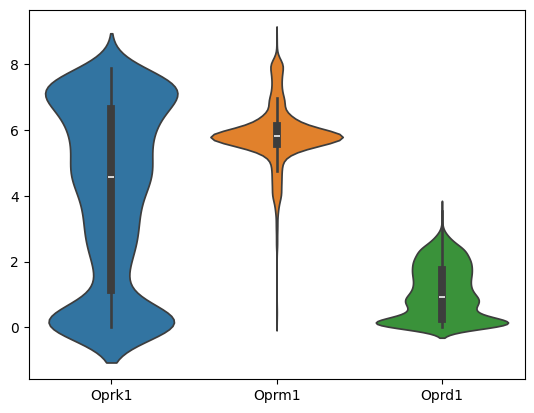

In [35]:
# prompt: create violin plot of table

import seaborn as sns

sns.violinplot(data=table)
plt.show()
